In [62]:
import numpy as np 
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt 
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
import os
import shutil
from tensorflow.keras import metrics
import matplotlib
#from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, RMSprop
plt.style.use('seaborn')


# Create X and y Data: Helper Functions

* create_X_and_y()

In [63]:
def create_X_and_y(X_filepath, y_filepath):
    
    ''' imports lined images and unlined images from jpeg files 
    into numpy arrays for use into autoencoder'''
    
    y_list = []
    for image in sorted(os.listdir(y_filepath)):
        file= y_filepath + str(image)
        y_image = np.array(Image.open(file))
        y_image = y_image.reshape(*y_image.shape,1)
        y_list.append(y_image)
                    
    y = np.array(y_list)  

    X_list = []
    for image in sorted(os.listdir(X_filepath)):
        file = X_filepath+str(image)
        X_image = np.array(Image.open(file))
        X_image = X_image.reshape(*X_image.shape,1)
        X_list.append(X_image)
        
    X = np.array(X_list)
    
    return X,y

# Model Setup: Helper Functions
* model:
    create_and_compile()
    fit_model()
    predict()
    
* plot:
    plot_loss()
    plot_accuracy()


In [18]:
def callbacks(model_name = 'model', early_stopping = False, patience = None):
    checkpoint_filepath = (f'./tmp/{model_name}/checkpoint')
    tensorboard = TensorBoard(log_dir=(f"./logs/{model_name}"),
                            
                            histogram_freq=2,
                            write_graph=True,
                            write_images=True,
                            update_freq="epoch",
                            profile_batch=2,
                            embeddings_freq=0,
                            embeddings_metadata=None)
    if early_stopping == True:
        early_stopping = EarlyStopping(monitor='loss',  patience=patience, restore_best_weights=True)
    model_cp = ModelCheckpoint(filepath=checkpoint_filepath, monitor = 'loss', save_best_only=True)
    
    return tensorboard, early_stopping, model_cp



In [64]:
def create_and_compile_sparse_model(optimizer='adam', learning_rate=.001, loss='mse', metrics='accuracy'):
    ''' creates and compiles model '''
    
    input_img = Input(shape=(500,400,1)) 
    x = Conv2D(32, (3, 3), activation='relu')(input_img)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = Dense(128)(x) 
    x= Conv2DTranspose(32,(3,3), activation='relu')(x)
    decoded = Conv2DTranspose(1, (3, 3), activation='linear', padding='same')(x)

    compile_optimizer = Adam(learning_rate=learning_rate)#if ever use different than Adam will need to change this line
    autoencoder = Model(input_img, decoded)
    autoencoder.summary()
    autoencoder.compile(optimizer=compile_optimizer, loss=loss, metrics=metrics)
    return autoencoder

In [67]:
def sequential_model(loss = 'mse', optimizer = 'adam', metrics=['accuracy']):
    '''creates and compiles a simple Sequential Model.'''
    
    model = Sequential()
    model.add(Input(shape=(500,400,1)))
  
    model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'))
    model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'))
    model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'))

    model.add(Dense(128,  activation='relu'))
    model.add(Dense(2,    activation='linear', name="bottleneck"))
    model.add(Dense(128,  activation='relu'))

    model.add(Conv2DTranspose(filters = 32, kernel_size=(3,3), activation='relu'))
    model.add(Conv2DTranspose(filters = 32, kernel_size=(3,3), activation='relu'))
    model.add(Conv2DTranspose(filters = 32, kernel_size=(3,3), activation='relu'))
    model.add(Conv2DTranspose(filters = 1, kernel_size=(3,3), activation='linear', padding='same'))

    model.summary()
    
    model.compile(loss = loss, optimizer = optimizer, metrics=metrics) 
    #does Saquential have a compile optimizer?
    return model




In [20]:
def fit_model(compiled_model, x=X, y=y, batch_size=15, epochs=50, verbose=1, callbacks=None, validation_split=0.2):

    history = compiled_model.fit(x=X, y=y, batch_size=batch_size, epochs = epochs, verbose=verbose, callbacks=callbacks, validation_split=validation_split)
    return history

In [21]:
def plot_loss(model_name, model_history, metric_1 = 'loss', color_1='blue', metric_1_label = 'Training Loss Score by Epoch', 
                 metric_2 = 'val_loss', color_2='green', metric_2_label = 'Validation Loss Score by Epoch'):
    
    plt.plot(model_history.history[metric_1], color=color_1, label=metric_1_label)
    plt.plot(model_history.history[metric_2], color=color_2, label=metric_2_label)
    plt.title(label=model_name)
    plt.legend()


In [22]:
def plot_accuracy(model_name, model_history, metric_3 = 'accuracy', color_3='red', metric_3_label = 'Training Accuracy Score by Epoch', 
                 metric_4 = 'val_accuracy', color_4='orange', metric_4_label = 'Validation Accuracy Score by Epoch'):
    
    plt.plot(model_history.history[metric_3], color=color_3, label=metric_3_label)
    plt.plot(model_history.history[metric_4], color=color_4, label=metric_4_label)
    plt.title(label=model_name)
    plt.legend()

In [23]:
def predict_image_on_X(fitted_model, X=X, index=0):
    result = fitted_model.predict(X)
    result[result>255]=255
    result[result<0] = 0
    result = result[index].astype(np.uint8).reshape(500,400)
    original = X[index].astype(np.uint8).reshape(500,400)
    
    return Image.fromarray(np.hstack([original, result]))

In [57]:
def predict_on_unseen(fitted_model, file_path_list):
    
    '''Removes the lines on images that the model has NOT seen. To see the images index into list that is returned.''' 
    
    
    if len(file_path_list)== 1:
        image_to_predict = np.array(Image.open(str(file_path_list)))
        result = fitted_model.predict(np.array([image_to_predict.reshape(*image_to_predict.shape, 1)]))
        result[result>255]=255
        result[result<0] = 0
        result = result.astype(np.uint8).reshape(500,400)
        return Image.fromarray(np.hstack([image_to_predict, result]))
                                    
    else:
        original_image_list = []
        result_image_list = []
        difference_list = []
        for idx, original_image in enumerate(file_path_list):
            original_image = np.array(Image.open(str(file_path_list[idx])))
            original_image_list.append(original_image)
                                      
            result = fitted_model.predict(np.array([original_image.reshape(*original_image.shape, 1)]))
            result[result>255]=255
            result[result<0] = 0
            result = result.astype(np.uint8).reshape(500,400)
            result_image_list.append(result)
            difference_list.append(result - original_image)
        all_results_list=[]
        for idx, images in enumerate(zip(original_image_list, result_image_list, difference_list)):
            all_results_list.append(Image.fromarray(np.hstack([original_image_list[idx], result_image_list[idx], difference_list[idx]])))
        return all_results_list


In [ ]:
def open_saved_model(model_name):
    model = load_model('path/to/model.h5')
    f'./tmp/{model_name}/checkpoint'
    

# The Models w/ Results

In [25]:
'''Create the data X,y '''
y_filepath = 'Data/y_variables/Unruled/'
X_filepath = 'Data/X_variables/computer_generated_lines/'

X,y = create_X_and_y(X_filepath, y_filepath)
X.shape, y.shape

((669, 500, 400, 1), (669, 500, 400, 1))

### Model Type 1: Sparse


In [65]:
#set up model callbacks
tensorboard, early_stopping, model_cp = callbacks(model_name = 'sparse_1', 
                                                  early_stopping = True, patience = 20)

#create and compile model
sparse_1 = create_and_compile_sparse_model(optimizer='adam', learning_rate=.0001, 
                                           loss='mse', metrics='accuracy')

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 500, 400, 1)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 498, 398, 32)      320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 498, 398, 8)       2312      
_________________________________________________________________
dense_2 (Dense)              (None, 498, 398, 128)     1152      
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 500, 400, 32)      36896     
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 500, 400, 1)       289       
Total params: 40,969
Trainable params: 40,969
Non-trainable params: 0
__________________________________________________

In [66]:
sparse_1_history = fit_model(sparse_1, x=X, y=y, batch_size=15, epochs=500, 
                             verbose=1, callbacks=[tensorboard,early_stopping,model_cp], validation_split=0.2)




Epoch 1/500
36/36 [==============================] - 5s 135ms/step - loss: 21207.0156 - accuracy: 4.5701e-06 - val_loss: 1301.7131 - val_accuracy: 9.7388e-06
Epoch 2/500
36/36 [==============================] - 5s 128ms/step - loss: 883.2357 - accuracy: 4.2617e-06 - val_loss: 645.4292 - val_accuracy: 9.7388e-06
Epoch 3/500
36/36 [==============================] - 5s 134ms/step - loss: 573.0790 - accuracy: 4.2617e-06 - val_loss: 574.0174 - val_accuracy: 9.7388e-06
Epoch 4/500
36/36 [==============================] - 5s 129ms/step - loss: 521.3382 - accuracy: 4.2617e-06 - val_loss: 520.6631 - val_accuracy: 9.7388e-06
Epoch 5/500
36/36 [==============================] - 5s 130ms/step - loss: 473.4892 - accuracy: 4.2617e-06 - val_loss: 473.2192 - val_accuracy: 9.7388e-06
Epoch 6/500
36/36 [==============================] - 5s 130ms/step - loss: 429.7360 - accuracy: 4.2617e-06 - val_loss: 426.2690 - val_accuracy: 9.7388e-06
Epoch 7/500
36/36 [==============================] - 5s 129ms/step 

36/36 [==============================] - 5s 131ms/step - loss: 58.2898 - accuracy: 4.2617e-06 - val_loss: 60.2895 - val_accuracy: 9.7761e-06
Epoch 27/500
36/36 [==============================] - 5s 136ms/step - loss: 54.6834 - accuracy: 4.2617e-06 - val_loss: 56.3031 - val_accuracy: 9.7761e-06
Epoch 28/500
36/36 [==============================] - 5s 131ms/step - loss: 51.4164 - accuracy: 4.2617e-06 - val_loss: 53.2578 - val_accuracy: 9.7761e-06
Epoch 29/500
36/36 [==============================] - 5s 131ms/step - loss: 48.6826 - accuracy: 4.2523e-06 - val_loss: 50.8386 - val_accuracy: 9.8134e-06
Epoch 30/500
36/36 [==============================] - 5s 131ms/step - loss: 46.2223 - accuracy: 4.2523e-06 - val_loss: 48.3043 - val_accuracy: 9.8134e-06
Epoch 31/500
36/36 [==============================] - 5s 132ms/step - loss: 43.7018 - accuracy: 4.2523e-06 - val_loss: 45.6239 - val_accuracy: 9.8134e-06
Epoch 32/500
36/36 [==============================] - 5s 136ms/step - loss: 41.6307 - acc

36/36 [==============================] - 5s 131ms/step - loss: 24.1428 - accuracy: 4.5981e-06 - val_loss: 25.7745 - val_accuracy: 1.1231e-05
Epoch 54/500
36/36 [==============================] - 5s 130ms/step - loss: 23.8488 - accuracy: 4.6449e-06 - val_loss: 25.8219 - val_accuracy: 1.1343e-05
Epoch 55/500
36/36 [==============================] - 5s 131ms/step - loss: 23.5431 - accuracy: 4.6542e-06 - val_loss: 25.2860 - val_accuracy: 1.1418e-05
Epoch 56/500
36/36 [==============================] - 5s 136ms/step - loss: 23.2514 - accuracy: 4.7664e-06 - val_loss: 24.8475 - val_accuracy: 1.1381e-05
Epoch 57/500
36/36 [==============================] - 5s 131ms/step - loss: 22.9487 - accuracy: 4.7850e-06 - val_loss: 24.6849 - val_accuracy: 1.1493e-05
Epoch 58/500
36/36 [==============================] - 5s 130ms/step - loss: 22.7048 - accuracy: 4.7944e-06 - val_loss: 24.2550 - val_accuracy: 1.1567e-05
Epoch 59/500
36/36 [==============================] - 5s 131ms/step - loss: 22.4910 - acc

36/36 [==============================] - 5s 131ms/step - loss: 18.0195 - accuracy: 5.3832e-06 - val_loss: 19.3834 - val_accuracy: 1.3433e-05
Epoch 81/500
36/36 [==============================] - 5s 137ms/step - loss: 17.8704 - accuracy: 5.5514e-06 - val_loss: 19.3152 - val_accuracy: 1.4478e-05
Epoch 82/500
36/36 [==============================] - 5s 131ms/step - loss: 17.7839 - accuracy: 5.6075e-06 - val_loss: 19.0601 - val_accuracy: 1.4440e-05
Epoch 83/500
36/36 [==============================] - 5s 131ms/step - loss: 17.5655 - accuracy: 5.7944e-06 - val_loss: 18.9468 - val_accuracy: 1.3582e-05
Epoch 84/500
36/36 [==============================] - 5s 131ms/step - loss: 17.4750 - accuracy: 5.8411e-06 - val_loss: 18.9770 - val_accuracy: 1.4179e-05
Epoch 85/500
36/36 [==============================] - 5s 131ms/step - loss: 17.3678 - accuracy: 5.9439e-06 - val_loss: 18.9050 - val_accuracy: 1.3694e-05
Epoch 86/500
36/36 [==============================] - 5s 136ms/step - loss: 17.3627 - acc

36/36 [==============================] - 5s 132ms/step - loss: 15.7100 - accuracy: 6.7009e-06 - val_loss: 17.0058 - val_accuracy: 1.6716e-05
Epoch 110/500
36/36 [==============================] - 5s 136ms/step - loss: 15.6710 - accuracy: 6.6449e-06 - val_loss: 17.0388 - val_accuracy: 1.7687e-05
Epoch 111/500
36/36 [==============================] - 4s 106ms/step - loss: 15.7129 - accuracy: 6.6729e-06 - val_loss: 16.8654 - val_accuracy: 1.8172e-05
Epoch 112/500
36/36 [==============================] - 4s 105ms/step - loss: 15.7167 - accuracy: 6.7477e-06 - val_loss: 16.8583 - val_accuracy: 1.7724e-05
Epoch 113/500
36/36 [==============================] - 5s 131ms/step - loss: 15.6357 - accuracy: 6.9252e-06 - val_loss: 16.7499 - val_accuracy: 1.8284e-05
Epoch 114/500
36/36 [==============================] - 5s 131ms/step - loss: 15.5899 - accuracy: 6.7477e-06 - val_loss: 16.7694 - val_accuracy: 1.8022e-05
Epoch 115/500
36/36 [==============================] - 5s 132ms/step - loss: 15.4718

Epoch 143/500
36/36 [==============================] - 5s 131ms/step - loss: 14.6227 - accuracy: 7.9720e-06 - val_loss: 15.9282 - val_accuracy: 1.9291e-05
Epoch 144/500
36/36 [==============================] - 4s 105ms/step - loss: 14.7599 - accuracy: 8.0748e-06 - val_loss: 15.8017 - val_accuracy: 2.1455e-05
Epoch 145/500
36/36 [==============================] - 4s 106ms/step - loss: 14.7325 - accuracy: 7.6262e-06 - val_loss: 16.5106 - val_accuracy: 2.0187e-05
Epoch 146/500
36/36 [==============================] - 4s 106ms/step - loss: 14.6836 - accuracy: 7.8972e-06 - val_loss: 15.7523 - val_accuracy: 2.0560e-05
Epoch 147/500
36/36 [==============================] - 5s 132ms/step - loss: 14.5077 - accuracy: 8.0841e-06 - val_loss: 15.6813 - val_accuracy: 2.0112e-05
Epoch 148/500
36/36 [==============================] - 4s 106ms/step - loss: 14.5693 - accuracy: 7.8972e-06 - val_loss: 15.7351 - val_accuracy: 2.1679e-05
Epoch 149/500
36/36 [==============================] - 4s 106ms/step -

Epoch 184/500
36/36 [==============================] - 4s 105ms/step - loss: 13.9642 - accuracy: 8.4579e-06 - val_loss: 15.1280 - val_accuracy: 2.2649e-05
Epoch 185/500
36/36 [==============================] - 5s 137ms/step - loss: 13.7674 - accuracy: 8.4579e-06 - val_loss: 15.0003 - val_accuracy: 2.2799e-05
Epoch 186/500
36/36 [==============================] - 4s 105ms/step - loss: 13.9340 - accuracy: 9.0748e-06 - val_loss: 14.8826 - val_accuracy: 2.1866e-05
Epoch 187/500
36/36 [==============================] - 5s 131ms/step - loss: 13.6864 - accuracy: 8.6542e-06 - val_loss: 15.0497 - val_accuracy: 2.1530e-05
Epoch 188/500
36/36 [==============================] - 4s 106ms/step - loss: 13.7551 - accuracy: 8.3458e-06 - val_loss: 15.6071 - val_accuracy: 2.2388e-05
Epoch 189/500
36/36 [==============================] - 4s 106ms/step - loss: 13.8990 - accuracy: 8.6449e-06 - val_loss: 14.9315 - val_accuracy: 2.0970e-05
Epoch 190/500
36/36 [==============================] - 4s 105ms/step -

36/36 [==============================] - 5s 131ms/step - loss: 13.1825 - accuracy: 9.2430e-06 - val_loss: 14.1344 - val_accuracy: 2.5373e-05
Epoch 226/500
36/36 [==============================] - 5s 132ms/step - loss: 13.1122 - accuracy: 8.7944e-06 - val_loss: 14.3683 - val_accuracy: 2.5672e-05
Epoch 227/500
36/36 [==============================] - 5s 131ms/step - loss: 13.0273 - accuracy: 9.2897e-06 - val_loss: 14.3491 - val_accuracy: 2.5149e-05
Epoch 228/500
36/36 [==============================] - 4s 106ms/step - loss: 13.6026 - accuracy: 9.1215e-06 - val_loss: 14.2492 - val_accuracy: 2.2537e-05
Epoch 229/500
36/36 [==============================] - 4s 106ms/step - loss: 13.0548 - accuracy: 8.7944e-06 - val_loss: 14.2890 - val_accuracy: 2.3097e-05
Epoch 230/500
36/36 [==============================] - 5s 131ms/step - loss: 12.9320 - accuracy: 9.3551e-06 - val_loss: 14.1164 - val_accuracy: 2.3284e-05
Epoch 231/500
36/36 [==============================] - 4s 106ms/step - loss: 13.0440

Epoch 267/500
36/36 [==============================] - 4s 106ms/step - loss: 12.5588 - accuracy: 9.6075e-06 - val_loss: 13.4782 - val_accuracy: 2.6045e-05
Epoch 268/500
36/36 [==============================] - 5s 131ms/step - loss: 12.4578 - accuracy: 9.4206e-06 - val_loss: 13.4732 - val_accuracy: 2.5000e-05
Epoch 269/500
36/36 [==============================] - 4s 106ms/step - loss: 13.1188 - accuracy: 1.0019e-05 - val_loss: 13.4738 - val_accuracy: 2.3582e-05
Epoch 270/500
36/36 [==============================] - 4s 106ms/step - loss: 12.4834 - accuracy: 9.1495e-06 - val_loss: 13.6041 - val_accuracy: 2.5000e-05
Epoch 271/500
36/36 [==============================] - 5s 136ms/step - loss: 12.3132 - accuracy: 9.5234e-06 - val_loss: 13.4381 - val_accuracy: 2.5970e-05
Epoch 272/500
36/36 [==============================] - 5s 132ms/step - loss: 12.2525 - accuracy: 9.3645e-06 - val_loss: 13.4315 - val_accuracy: 2.6604e-05
Epoch 273/500
36/36 [==============================] - 4s 106ms/step -

Epoch 307/500
36/36 [==============================] - 5s 131ms/step - loss: 11.8740 - accuracy: 1.0243e-05 - val_loss: 12.9792 - val_accuracy: 2.5448e-05
Epoch 308/500
36/36 [==============================] - 4s 105ms/step - loss: 12.0797 - accuracy: 1.0308e-05 - val_loss: 13.4332 - val_accuracy: 2.5522e-05
Epoch 309/500
36/36 [==============================] - 4s 106ms/step - loss: 12.0043 - accuracy: 1.0757e-05 - val_loss: 13.6100 - val_accuracy: 2.5784e-05
Epoch 310/500
36/36 [==============================] - 4s 106ms/step - loss: 12.0770 - accuracy: 9.8879e-06 - val_loss: 12.9630 - val_accuracy: 2.5821e-05
Epoch 311/500
36/36 [==============================] - 4s 106ms/step - loss: 12.2500 - accuracy: 1.0280e-05 - val_loss: 12.9594 - val_accuracy: 2.4552e-05
Epoch 312/500
36/36 [==============================] - 4s 106ms/step - loss: 12.0355 - accuracy: 1.0168e-05 - val_loss: 12.9626 - val_accuracy: 2.5672e-05
Epoch 313/500
36/36 [==============================] - 4s 106ms/step -

Epoch 351/500
36/36 [==============================] - 4s 106ms/step - loss: 11.4539 - accuracy: 9.7383e-06 - val_loss: 13.6140 - val_accuracy: 2.6604e-05
Epoch 352/500
36/36 [==============================] - 4s 106ms/step - loss: 11.9987 - accuracy: 9.7009e-06 - val_loss: 12.4748 - val_accuracy: 2.6082e-05
Epoch 353/500
36/36 [==============================] - 5s 132ms/step - loss: 11.3341 - accuracy: 9.8037e-06 - val_loss: 12.4591 - val_accuracy: 2.6231e-05
Epoch 354/500
36/36 [==============================] - 4s 106ms/step - loss: 11.4030 - accuracy: 9.8131e-06 - val_loss: 12.6290 - val_accuracy: 2.6903e-05
Epoch 355/500
36/36 [==============================] - 4s 106ms/step - loss: 11.4701 - accuracy: 9.8224e-06 - val_loss: 12.9257 - val_accuracy: 2.6194e-05
Epoch 356/500
36/36 [==============================] - 4s 106ms/step - loss: 11.5104 - accuracy: 1.0327e-05 - val_loss: 12.3957 - val_accuracy: 2.5112e-05
Epoch 357/500
36/36 [==============================] - 4s 106ms/step -

36/36 [==============================] - 5s 132ms/step - loss: 10.9025 - accuracy: 1.0075e-05 - val_loss: 12.1870 - val_accuracy: 2.5410e-05
Epoch 396/500
36/36 [==============================] - 4s 105ms/step - loss: 11.1493 - accuracy: 9.9439e-06 - val_loss: 12.1260 - val_accuracy: 2.4851e-05
Epoch 397/500
36/36 [==============================] - 5s 137ms/step - loss: 10.8485 - accuracy: 9.6636e-06 - val_loss: 11.9355 - val_accuracy: 2.4216e-05
Epoch 398/500
36/36 [==============================] - 4s 106ms/step - loss: 10.9671 - accuracy: 9.4019e-06 - val_loss: 11.9491 - val_accuracy: 2.5597e-05
Epoch 399/500
36/36 [==============================] - 4s 106ms/step - loss: 10.8621 - accuracy: 9.6822e-06 - val_loss: 12.0118 - val_accuracy: 2.5821e-05
Epoch 400/500
36/36 [==============================] - 4s 106ms/step - loss: 11.3001 - accuracy: 1.0047e-05 - val_loss: 14.1978 - val_accuracy: 2.4328e-05
Epoch 401/500
36/36 [==============================] - 4s 106ms/step - loss: 11.7136

Epoch 437/500
36/36 [==============================] - 4s 106ms/step - loss: 10.6045 - accuracy: 1.0084e-05 - val_loss: 11.6770 - val_accuracy: 2.7052e-05
Epoch 438/500
36/36 [==============================] - 4s 106ms/step - loss: 10.8064 - accuracy: 1.0776e-05 - val_loss: 12.1990 - val_accuracy: 2.4030e-05
Epoch 439/500
36/36 [==============================] - 4s 107ms/step - loss: 10.7228 - accuracy: 1.0308e-05 - val_loss: 13.0950 - val_accuracy: 2.4963e-05
Epoch 440/500
36/36 [==============================] - 4s 106ms/step - loss: 10.8297 - accuracy: 9.8879e-06 - val_loss: 11.5925 - val_accuracy: 2.6493e-05
Epoch 441/500
36/36 [==============================] - 4s 106ms/step - loss: 10.5812 - accuracy: 1.0374e-05 - val_loss: 11.6438 - val_accuracy: 2.7201e-05
Epoch 442/500
36/36 [==============================] - 5s 132ms/step - loss: 10.4645 - accuracy: 1.0551e-05 - val_loss: 11.6811 - val_accuracy: 2.7948e-05
Epoch 443/500
36/36 [==============================] - 4s 106ms/step -

Epoch 483/500
36/36 [==============================] - 5s 132ms/step - loss: 10.1781 - accuracy: 1.2355e-05 - val_loss: 11.2126 - val_accuracy: 2.8507e-05
Epoch 484/500
36/36 [==============================] - 4s 106ms/step - loss: 10.5646 - accuracy: 1.1935e-05 - val_loss: 11.4023 - val_accuracy: 3.0261e-05
Epoch 485/500
36/36 [==============================] - 4s 106ms/step - loss: 10.4027 - accuracy: 1.1542e-05 - val_loss: 11.2847 - val_accuracy: 3.3470e-05
Epoch 486/500
36/36 [==============================] - 5s 136ms/step - loss: 10.1759 - accuracy: 1.1710e-05 - val_loss: 11.1826 - val_accuracy: 3.5075e-05
Epoch 487/500
36/36 [==============================] - 5s 132ms/step - loss: 10.1443 - accuracy: 1.3617e-05 - val_loss: 11.2554 - val_accuracy: 3.0709e-05
Epoch 488/500
36/36 [==============================] - 4s 106ms/step - loss: 10.1787 - accuracy: 1.2093e-05 - val_loss: 11.2473 - val_accuracy: 3.4813e-05
Epoch 489/500
36/36 [==============================] - 4s 106ms/step -

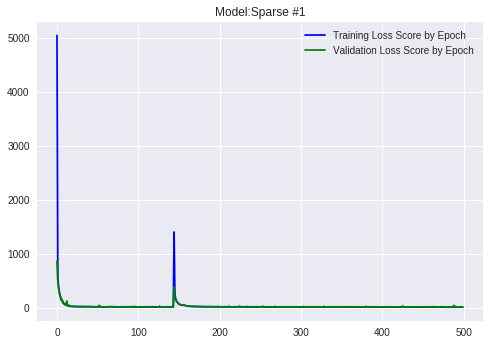

In [35]:
name = 'Model:Sparse #1'
plot_loss(name, sparse_1_history)

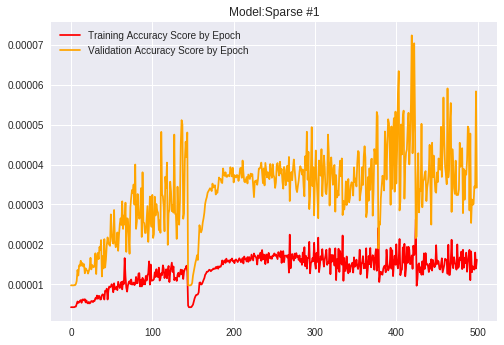

In [36]:
plot_accuracy(name, sparse_1_history)

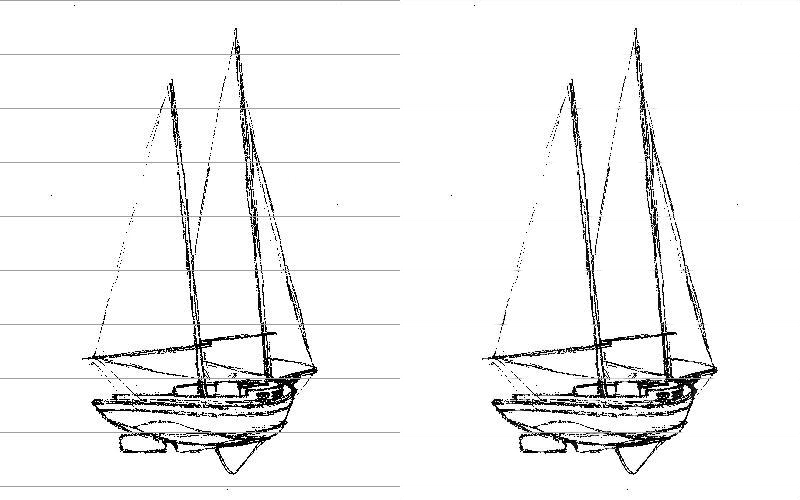

In [37]:
predict_image_on_X(sparse_1)


In [60]:
file_paths = ['Data/Original_Ruled/IMG_0003.jpg', 'Data/Original_Ruled/IMG_0005.jpg',
              'Data/Original_Ruled/IMG_0008.jpg','Data/Original_Ruled/IMG_0012.jpg',
              'Data/Original_Ruled/IMG_0035.jpg','Data/Original_Ruled/IMG_0042.jpg',
              'Data/Original_Ruled/IMG_0045.jpg','Data/Original_Ruled/IMG_0296.jpg',
              'Data/Original_Ruled/Sketch60s_0095.jpg']
#file_path = 'Data/Original_Ruled/IMG_0003.jpg'
unseen = predict_on_unseen(sparse_1, file_paths)

unseen[0]

In [49]:
#unseen[1]

In [48]:
#unseen[2]

In [54]:
#unseen[3]

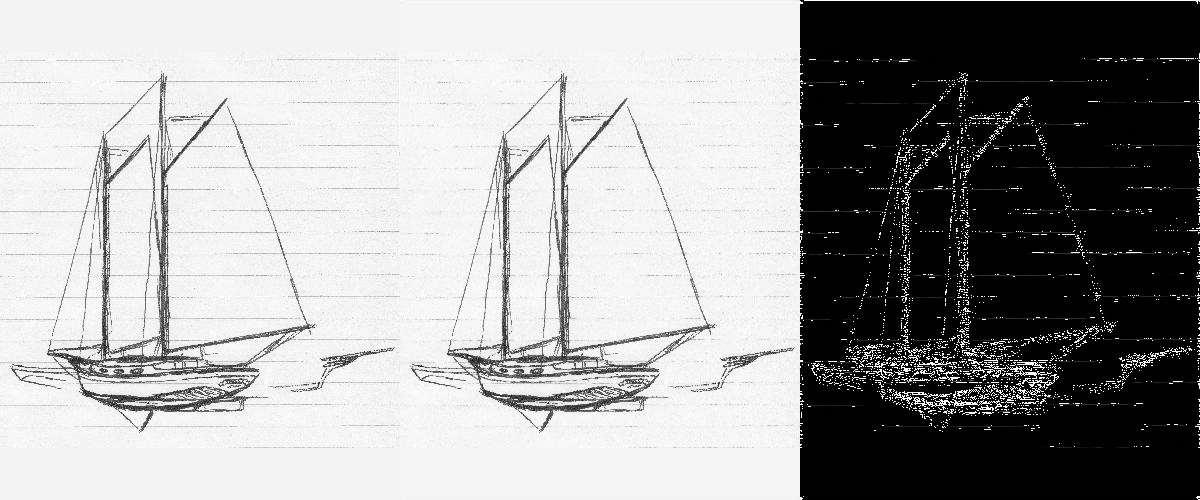

In [61]:
#unseen[4]

In [51]:
#unseen[5]

In [52]:
#unseen[6]



In [53]:
#unseen[7]# next try - save this 'enhanced' figure - then apply this model to the enhanced figure - see results

Question for Land - or anyone - how do i get score for (# of same value of pixels/total value of pixels) = difference in pixel colors: image 1(ex. (pixel color = range (0-256)) v pixel location

## Model Type 2: Sequential

In [156]:
#Model 2
tensorboard, early_stopping, model_cp = callbacks(model_name = 'sparse_1', early_stopping = True, patience = 300)
Sequential_1 = create_and_compile_sparse_model(optimizer='adam', loss='mse', metrics='accuracy')

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 500, 400, 1)]     0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 498, 398, 32)      320       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 498, 398, 8)       2312      
_________________________________________________________________
dense_4 (Dense)              (None, 498, 398, 128)     1152      
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 500, 400, 32)      36896     
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 500, 400, 1)       289       
Total params: 40,969
Trainable params: 40,969
Non-trainable params: 0
__________________________________________________

In [157]:
Sequential_1_history = fit_model(sparse_2, x=X, y=y, batch_size=15, epochs=500, verbose=1, 
                             callbacks=[tensorboard, early_stopping, model_cp], 
                             validation_split=0.2)

Epoch 1/500
36/36 [==============================] - 5s 132ms/step - loss: 7242.7759 - accuracy: 4.3271e-06 - val_loss: 689.8651 - val_accuracy: 9.7388e-06
Epoch 2/500
36/36 [==============================] - 5s 126ms/step - loss: 556.2215 - accuracy: 4.2617e-06 - val_loss: 484.2743 - val_accuracy: 9.7388e-06
Epoch 3/500
36/36 [==============================] - 5s 132ms/step - loss: 417.6718 - accuracy: 4.2617e-06 - val_loss: 390.6974 - val_accuracy: 9.7388e-06
Epoch 4/500
36/36 [==============================] - 5s 126ms/step - loss: 317.2808 - accuracy: 4.2617e-06 - val_loss: 274.5713 - val_accuracy: 1.0336e-05
Epoch 5/500
36/36 [==============================] - 5s 127ms/step - loss: 234.7612 - accuracy: 4.5888e-06 - val_loss: 199.9008 - val_accuracy: 1.5709e-05
Epoch 6/500
36/36 [==============================] - 5s 126ms/step - loss: 165.0959 - accuracy: 5.2056e-06 - val_loss: 158.1951 - val_accuracy: 1.3396e-05
Epoch 7/500
36/36 [==============================] - 5s 127ms/step - 

Epoch 29/500
36/36 [==============================] - 4s 104ms/step - loss: 22.1323 - accuracy: 6.9159e-06 - val_loss: 18.5906 - val_accuracy: 1.9328e-05
Epoch 30/500
36/36 [==============================] - 5s 128ms/step - loss: 16.8436 - accuracy: 6.1869e-06 - val_loss: 19.1202 - val_accuracy: 1.5858e-05
Epoch 31/500
36/36 [==============================] - 5s 129ms/step - loss: 16.6063 - accuracy: 6.2897e-06 - val_loss: 17.7951 - val_accuracy: 1.5112e-05
Epoch 32/500
36/36 [==============================] - 5s 127ms/step - loss: 16.1387 - accuracy: 6.9159e-06 - val_loss: 18.1668 - val_accuracy: 1.5224e-05
Epoch 33/500
36/36 [==============================] - 5s 128ms/step - loss: 16.1294 - accuracy: 6.6729e-06 - val_loss: 18.6646 - val_accuracy: 1.6007e-05
Epoch 34/500
36/36 [==============================] - 4s 104ms/step - loss: 16.8107 - accuracy: 6.5327e-06 - val_loss: 31.4009 - val_accuracy: 2.2239e-05
Epoch 35/500
36/36 [==============================] - 4s 104ms/step - loss: 

Epoch 66/500
36/36 [==============================] - 4s 104ms/step - loss: 17.6713 - accuracy: 8.3458e-06 - val_loss: 18.1475 - val_accuracy: 2.0149e-05
Epoch 67/500
36/36 [==============================] - 4s 104ms/step - loss: 13.8123 - accuracy: 8.4673e-06 - val_loss: 14.2014 - val_accuracy: 2.2425e-05
Epoch 68/500
36/36 [==============================] - 4s 104ms/step - loss: 13.5693 - accuracy: 8.6262e-06 - val_loss: 14.2627 - val_accuracy: 2.2463e-05
Epoch 69/500
36/36 [==============================] - 4s 105ms/step - loss: 13.7176 - accuracy: 8.8785e-06 - val_loss: 16.6435 - val_accuracy: 2.0336e-05
Epoch 70/500
36/36 [==============================] - 4s 104ms/step - loss: 14.5310 - accuracy: 1.0121e-05 - val_loss: 13.9220 - val_accuracy: 2.2687e-05
Epoch 71/500
36/36 [==============================] - 5s 135ms/step - loss: 13.2997 - accuracy: 8.1589e-06 - val_loss: 19.6735 - val_accuracy: 2.7388e-05
Epoch 72/500
36/36 [==============================] - 4s 104ms/step - loss: 

36/36 [==============================] - 4s 105ms/step - loss: 13.0368 - accuracy: 1.2056e-05 - val_loss: 12.5937 - val_accuracy: 2.9179e-05
Epoch 114/500
36/36 [==============================] - 4s 104ms/step - loss: 14.9290 - accuracy: 1.1607e-05 - val_loss: 13.0036 - val_accuracy: 3.5187e-05
Epoch 115/500
36/36 [==============================] - 4s 105ms/step - loss: 12.6463 - accuracy: 1.1935e-05 - val_loss: 23.1706 - val_accuracy: 3.3731e-05
Epoch 116/500
36/36 [==============================] - 4s 105ms/step - loss: 16.9041 - accuracy: 1.0234e-05 - val_loss: 12.5013 - val_accuracy: 3.4701e-05
Epoch 117/500
36/36 [==============================] - 4s 105ms/step - loss: 12.7927 - accuracy: 1.4196e-05 - val_loss: 20.9123 - val_accuracy: 2.4254e-05
Epoch 118/500
36/36 [==============================] - 4s 104ms/step - loss: 17.1929 - accuracy: 8.1308e-06 - val_loss: 26.0381 - val_accuracy: 2.4216e-05
Epoch 119/500
36/36 [==============================] - 4s 105ms/step - loss: 14.5144

Epoch 161/500
36/36 [==============================] - 4s 105ms/step - loss: 16.4630 - accuracy: 1.6561e-05 - val_loss: 22.2866 - val_accuracy: 4.9067e-05
Epoch 162/500
36/36 [==============================] - 4s 104ms/step - loss: 12.9103 - accuracy: 1.4009e-05 - val_loss: 11.6380 - val_accuracy: 3.6343e-05
Epoch 163/500
36/36 [==============================] - 5s 129ms/step - loss: 10.2285 - accuracy: 1.6000e-05 - val_loss: 11.6252 - val_accuracy: 3.6381e-05
Epoch 164/500
36/36 [==============================] - 4s 104ms/step - loss: 11.2602 - accuracy: 1.7776e-05 - val_loss: 11.1851 - val_accuracy: 3.6866e-05
Epoch 165/500
36/36 [==============================] - 4s 105ms/step - loss: 13.0598 - accuracy: 1.5822e-05 - val_loss: 15.7822 - val_accuracy: 4.6530e-05
Epoch 166/500
36/36 [==============================] - 4s 104ms/step - loss: 20.0312 - accuracy: 1.6131e-05 - val_loss: 18.0190 - val_accuracy: 3.4291e-05
Epoch 167/500
36/36 [==============================] - 4s 105ms/step -

Epoch 209/500
36/36 [==============================] - 4s 105ms/step - loss: 10.5600 - accuracy: 1.6673e-05 - val_loss: 10.4499 - val_accuracy: 4.4403e-05
Epoch 210/500
36/36 [==============================] - 5s 129ms/step - loss: 9.2847 - accuracy: 1.5785e-05 - val_loss: 10.9085 - val_accuracy: 5.2724e-05
Epoch 211/500
36/36 [==============================] - 4s 105ms/step - loss: 10.1087 - accuracy: 1.7935e-05 - val_loss: 10.5880 - val_accuracy: 4.5000e-05
Epoch 212/500
36/36 [==============================] - 4s 104ms/step - loss: 10.3624 - accuracy: 1.7477e-05 - val_loss: 16.0624 - val_accuracy: 4.6157e-05
Epoch 213/500
36/36 [==============================] - 4s 105ms/step - loss: 47.8389 - accuracy: 1.6991e-05 - val_loss: 58.1102 - val_accuracy: 2.3396e-05
Epoch 214/500
36/36 [==============================] - 4s 104ms/step - loss: 41.0010 - accuracy: 2.8869e-05 - val_loss: 17.2964 - val_accuracy: 3.1119e-05
Epoch 215/500
36/36 [==============================] - 4s 105ms/step - 

Epoch 261/500
36/36 [==============================] - 4s 105ms/step - loss: 11.2686 - accuracy: 1.4860e-05 - val_loss: 11.6009 - val_accuracy: 4.5075e-05
Epoch 262/500
36/36 [==============================] - 4s 104ms/step - loss: 10.3955 - accuracy: 1.2523e-05 - val_loss: 10.2842 - val_accuracy: 4.2873e-05
Epoch 263/500
36/36 [==============================] - 4s 105ms/step - loss: 11.6431 - accuracy: 1.3720e-05 - val_loss: 10.7068 - val_accuracy: 4.6269e-05
Epoch 264/500
36/36 [==============================] - 4s 104ms/step - loss: 11.4010 - accuracy: 1.3692e-05 - val_loss: 11.4081 - val_accuracy: 4.9030e-05
Epoch 265/500
36/36 [==============================] - 4s 105ms/step - loss: 9.4171 - accuracy: 1.5224e-05 - val_loss: 12.8994 - val_accuracy: 4.4627e-05
Epoch 266/500
36/36 [==============================] - 5s 129ms/step - loss: 9.1519 - accuracy: 1.5916e-05 - val_loss: 10.7094 - val_accuracy: 4.0373e-05
Epoch 267/500
36/36 [==============================] - 4s 105ms/step - l

36/36 [==============================] - 4s 105ms/step - loss: 9.9859 - accuracy: 1.0514e-05 - val_loss: 11.1181 - val_accuracy: 2.7351e-05
Epoch 310/500
36/36 [==============================] - 4s 105ms/step - loss: 9.8639 - accuracy: 2.0673e-05 - val_loss: 16.9741 - val_accuracy: 5.1754e-05
Epoch 311/500
36/36 [==============================] - 4s 105ms/step - loss: 12.4293 - accuracy: 1.9991e-05 - val_loss: 12.5652 - val_accuracy: 4.3843e-05
Epoch 312/500
36/36 [==============================] - 4s 105ms/step - loss: 9.1188 - accuracy: 1.9121e-05 - val_loss: 10.2583 - val_accuracy: 4.2090e-05
Epoch 313/500
36/36 [==============================] - 4s 105ms/step - loss: 9.3570 - accuracy: 1.6981e-05 - val_loss: 11.9364 - val_accuracy: 4.7873e-05
Epoch 314/500
36/36 [==============================] - 4s 104ms/step - loss: 10.5514 - accuracy: 2.1505e-05 - val_loss: 15.5350 - val_accuracy: 2.6493e-05
Epoch 315/500
36/36 [==============================] - 4s 105ms/step - loss: 10.3812 - a

Epoch 411/500
36/36 [==============================] - 4s 104ms/step - loss: 10.1550 - accuracy: 1.4664e-05 - val_loss: 13.1534 - val_accuracy: 3.2500e-05
Epoch 412/500
36/36 [==============================] - 4s 103ms/step - loss: 10.3396 - accuracy: 1.5439e-05 - val_loss: 11.4957 - val_accuracy: 3.7948e-05
Epoch 413/500
36/36 [==============================] - 4s 104ms/step - loss: 10.5623 - accuracy: 1.5607e-05 - val_loss: 11.5069 - val_accuracy: 3.3769e-05
Epoch 414/500
36/36 [==============================] - 4s 104ms/step - loss: 9.7600 - accuracy: 1.7692e-05 - val_loss: 10.9696 - val_accuracy: 3.6642e-05
Epoch 415/500
36/36 [==============================] - 4s 104ms/step - loss: 9.6979 - accuracy: 1.5178e-05 - val_loss: 12.6266 - val_accuracy: 3.3843e-05
Epoch 416/500
36/36 [==============================] - 4s 104ms/step - loss: 9.8676 - accuracy: 1.6551e-05 - val_loss: 11.1052 - val_accuracy: 3.8470e-05
Epoch 417/500
36/36 [==============================] - 4s 104ms/step - lo

36/36 [==============================] - 4s 103ms/step - loss: 11.6271 - accuracy: 1.9477e-05 - val_loss: 11.2525 - val_accuracy: 4.1754e-05
Epoch 465/500
36/36 [==============================] - 4s 104ms/step - loss: 52.7728 - accuracy: 2.2065e-05 - val_loss: 942.0027 - val_accuracy: 5.6007e-05
Epoch 466/500
36/36 [==============================] - 4s 103ms/step - loss: 431.3785 - accuracy: 2.3028e-05 - val_loss: 109.0397 - val_accuracy: 1.6604e-05
Epoch 467/500
36/36 [==============================] - 4s 103ms/step - loss: 77.0045 - accuracy: 1.2028e-05 - val_loss: 62.7996 - val_accuracy: 2.8619e-05
Epoch 468/500
36/36 [==============================] - 4s 103ms/step - loss: 54.5491 - accuracy: 1.3636e-05 - val_loss: 52.1735 - val_accuracy: 5.0485e-05
Epoch 469/500
36/36 [==============================] - 4s 103ms/step - loss: 43.3804 - accuracy: 2.7084e-05 - val_loss: 41.2442 - val_accuracy: 4.9291e-05
Epoch 470/500
36/36 [==============================] - 4s 103ms/step - loss: 35.4

In [46]:
plot_accuracy(Sequential_1_history)

NameError: name 'sparse_2_history' is not defined

In [47]:
plot_loss(Sequential_1_history)

NameError: name 'sparse_2_history' is not defined

In [ ]:
predict_image_on_X(Sequential_1)

In [ ]:
unseen_2 = predict_on_unseen(Sequential_1, file_paths)

JUNK BELOW THIS LINE:

In [ ]:
image_to_predict = np.array(Image.open('Data/Original_Ruled/IMG_0003.jpg'))

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))

ax[0].imshow(scharr)
ax[0].set_title('Scharr')
ax[0].axis('off')

ax[1].imshow(scharr_h)
ax[1].set_title('Scharr Horizontal')
ax[1].axis('off')

ax[2].imshow(scharr_v)
ax[2].set_title('Scharr Vertical')
ax[2].axis('off')
